In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import sys

sys.path.append("../")

from tqdm import tqdm_notebook
from src import NesterovFunc, NesterovMUFunc, STM


In [31]:
def rotate(y: np.array, a: float):
    x = np.diag(np.ones(len(y)))
    for i in range(5):
        j = 2 * i
        x[j][j] = np.sqrt(1 - a ** 2)
        x[j + 1][j] = a
        x[j][j + 1] = -a
        x[j + 1][j + 1] = np.sqrt(1 - a ** 2)
    z = x @ y
    return z
    

In [32]:
def gen_enemy_estimation(g: np.ndarray, v: np.ndarray, cos_rot: float) -> np.array:
    if cos_rot > 0.999:
        return g
    gn = np.linalg.norm(g)
    vn = np.linalg.norm(v)
    sc = (g * v).sum()
    A = [[gn ** 2, sc], [sc, vn ** 2]]
    cos_phi_0 = sc / gn / vn
    sin_phi_0 = np.sqrt(1 - cos_phi_0 ** 2)
    cos_sum = cos_phi_0 * cos_rot - sin_phi_0 * np.sqrt(1 - cos_rot ** 2)
    b = [(gn ** 2) * (cos_rot ** 2), gn * vn * cos_sum * cos_rot]
    # print(A, b)
    cg, cv = np.linalg.solve(A, b)
    return cg * g + cv * v


In [33]:
class NesterovFuncEnemy(NesterovFunc):

    def estimation_grad(self, x, direction_point, x_star):
        g = self.grad(x)
        size = self.alpha * np.linalg.norm(g)
        diff = direction_point - x_star
        noise = diff / np.linalg.norm(diff) * size
        est = g - noise
        return est


class NesterovMUFuncEnemy(NesterovMUFunc):

    def estimation_grad(self, x, direction_point, x_star):
        g = self.grad(x)
        size = self.alpha * np.linalg.norm(g)
        diff = direction_point - x_star
        noise = diff / np.linalg.norm(diff) * size
        est = g - noise
        return est



In [36]:
def nesterov_plot(iters: int = 100):
    L = 10
    dim = 1001
    k = 3
    # start = np.ones(dim) * 100
    start = np.zeros(dim)
    start[0] = 1000
    nesterov = NesterovFuncEnemy(L=L, d=dim, alpha=0.5, k=k)
    stm = STM(start=start, L=L, mu=0, func=nesterov)
    nesterov_true = NesterovFuncEnemy(L=L, d=dim, alpha=0, k=k)
    stm_true = STM(start=start, L=L, mu=0, func=nesterov_true)

    for _ in tqdm_notebook(range(iters)):
        stm.step()
        stm_true.step()
    with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
        plt.figure(figsize=(10, 6), dpi=120)
        xs = stm.x
        xst = stm_true.x
        values = [nesterov(x) for x in xs]
        plt.plot(np.arange(len(xs)), values, label="Noise")
        plt.plot(np.arange(len(xs)), [nesterov(x) for x in xst], label="Real")
        # plt.semilogy(np.arange(len(xs)), 100 / (1 + np.arange(len(xs))) ** 2)
        plt.legend()
        plt.show()
    return xs

/tmp/ipykernel_58808/1698845170.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(iters)):


  0%|          | 0/100 [00:00<?, ?it/s]

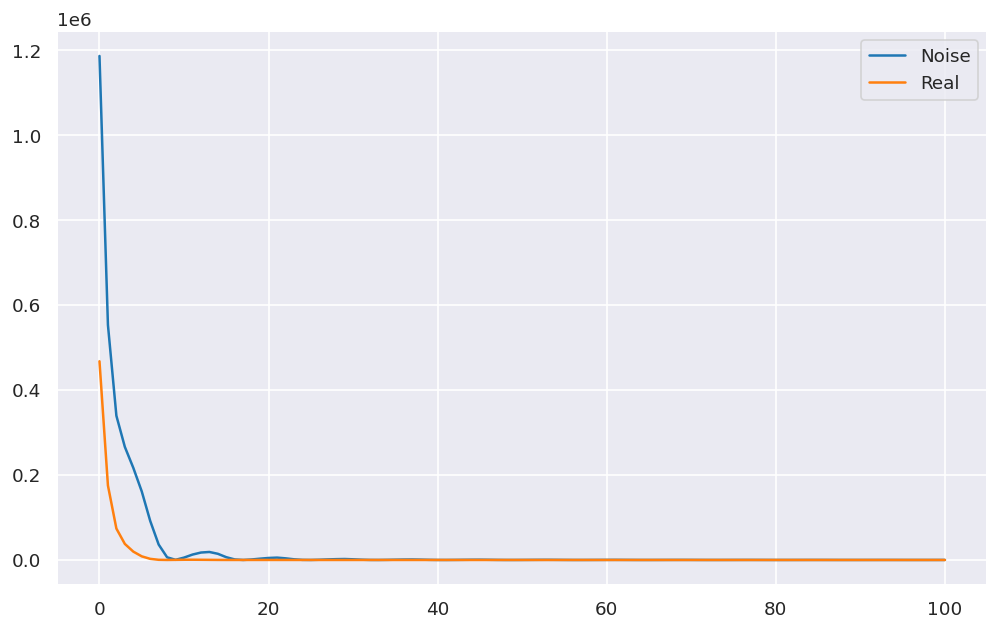

[array([ 7.79646421e+02,  2.49720882e+02, -2.78838465e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 array([546.63195781, 456.35587052, 100.0314566 , ...,   0.        ,
          0.        ,   0.        ]),
 array([395.95937188, 469.39074987, 244.05100989, ...,   0.        ,
          0.        ,   0.        ]),
 array([294.29882617, 427.40366247, 308.47343897, ...,   0.        ,
          0.        ,   0.        ]),
 array([231.34949279, 377.96175162, 306.49548677, ...,   0.        ,
          0.        ,   0.        ]),
 array([204.23783331, 328.92370267, 259.87519828, ...,   0.        ,
          0.        ,   0.        ]),
 array([188.6884021 , 250.19668703, 165.5572169 , ...,   0.        ,
          0.        ,   0.        ]),
 array([131.98324296, 151.28114493,  82.42425844, ...,   0.        ,
          0.        ,   0.        ]),
 array([58.0774974 , 58.29523057, 24.65702489, ...,  0.        ,
         0.        ,  0.        ]),
 array([ -3.22366304, -11

In [37]:
nesterov_plot(100)